In [1]:
# August 25 2017
# This file is for experiments with student2 4 skills and training trajectory length 5
# to check different architectures and whether they can learn good models
# This uses student2a where transitions happen after observations

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import six
from matplotlib.pyplot import *

def graph_trainauc_score(vloss, scores):
    figure()
    xs = np.sum(vloss,axis=1)
    ys = scores
    title('Training Loss AUC versus Actual Performance')
    xlabel('Training Loss AUC')
    ylabel('Posttest Score')
    plot(xs,ys,'.')
    ylim(0,1)

def graph_trainauc_qval(vloss, qval):
    figure()
    xs = np.sum(vloss,axis=1)
    ys = qval
    title('Training Loss AUC versus Own Qvalue')
    xlabel('Training Loss AUC')
    ylabel('Qvalue')
    plot(xs,ys,'.')

def graph_qval_score(qval, scores):
    figure()
    xs = qval
    ys = scores
    title('Own Qval versus Actual Performance')
    xlabel('Qvalue')
    ylabel('Posttest Score')
    plot(xs,ys,'.')

# Learning Rate 0.0005 Stability

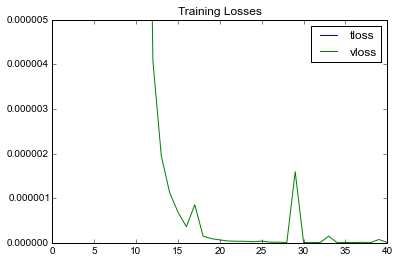

In [7]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.000005)
legend()
# looks like after 20 is enough. Use 25.